## comportamiento de la banda en funcion del tiempo

Este modo de operacion calcula los espectrogramas 

In [1]:
import psycopg2
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
#%matplotlib notebook
%matplotlib inline

def promedio(espectro, nfft):
    """ Realiza promedios del espectro,
    debido a que las muestras estan almacenadas en un vector de tamano N
    que se subdivide N/nfft veces y ese es el numero que se promedia (K)"""
    K = int(len(espectro)/(nfft))
    x = numpy.zeros(nfft)
    for i in range(K):
        x = x + espectro[i*nfft:(i+1)*nfft]
    x = x/K
    return x   

1) seleccionar banda espectral

2) extraer espectro y extraer fechas

3) crear la matriz espectro, tiempo, frecuencia



In [2]:
conn = psycopg2.connect(database="centrotic", user="postgres",
                      password="raspberry", host="127.0.0.1",
                      port="5432")
cur = conn.cursor()

## 1) extraccion de espectros

In [3]:
frec_central = [86000000,]
nfft = 1024
frec_muestreo = 16000000
query1 = "SELECT espectro, fecha FROM radioastronomia_espectro WHERE (frec_central = "+str(frec_central[0])+ " AND nfft="+str(nfft)+ " AND frec_muestreo="+str(frec_muestreo)+");"
print(query1)

SELECT espectro, fecha FROM radioastronomia_espectro WHERE (frec_central = 86000000 AND nfft=1024 AND frec_muestreo=16000000);


In [4]:
cur.execute(query1)
rows = cur.fetchall()
print(len(rows))

10


In [37]:
espectrograma = pd.DataFrame(columns=["Frecuencia", "Tiempo", "espectro"])
k = 0
char_ener = []
tiempo = []

frecuencia = []
espec = []
date = []

for row in rows:
    #este ciclo es la dimension del tiempo
    espectro = row[0]
    fecha = row[1]
    espectro = numpy.asarray(espectro)
    #promedio los espectros por cada tiempo escogido
    espectro = promedio(espectro=espectro, nfft=nfft)
    char_ener.append(numpy.sum(10**(espectro/10)))
    tiempo.append(fecha.strftime('%d %H:%M:%S'))
    f = numpy.arange(-int(nfft/2),int(nfft/2),1)*frec_muestreo/(nfft*2) + frec_central[0]
    for i in range(nfft):
        frecuencia.append(f[i]/1e6)
        date.append(fecha.strftime('%m-%d %H:%M:%S'))
        espec.append(espectro[i])
        
df = pd.DataFrame(data={"Frecuencia":frecuencia, "Tiempo":date, "espectro": espec})
df = df.pivot("Tiempo", "Frecuencia", "espectro")

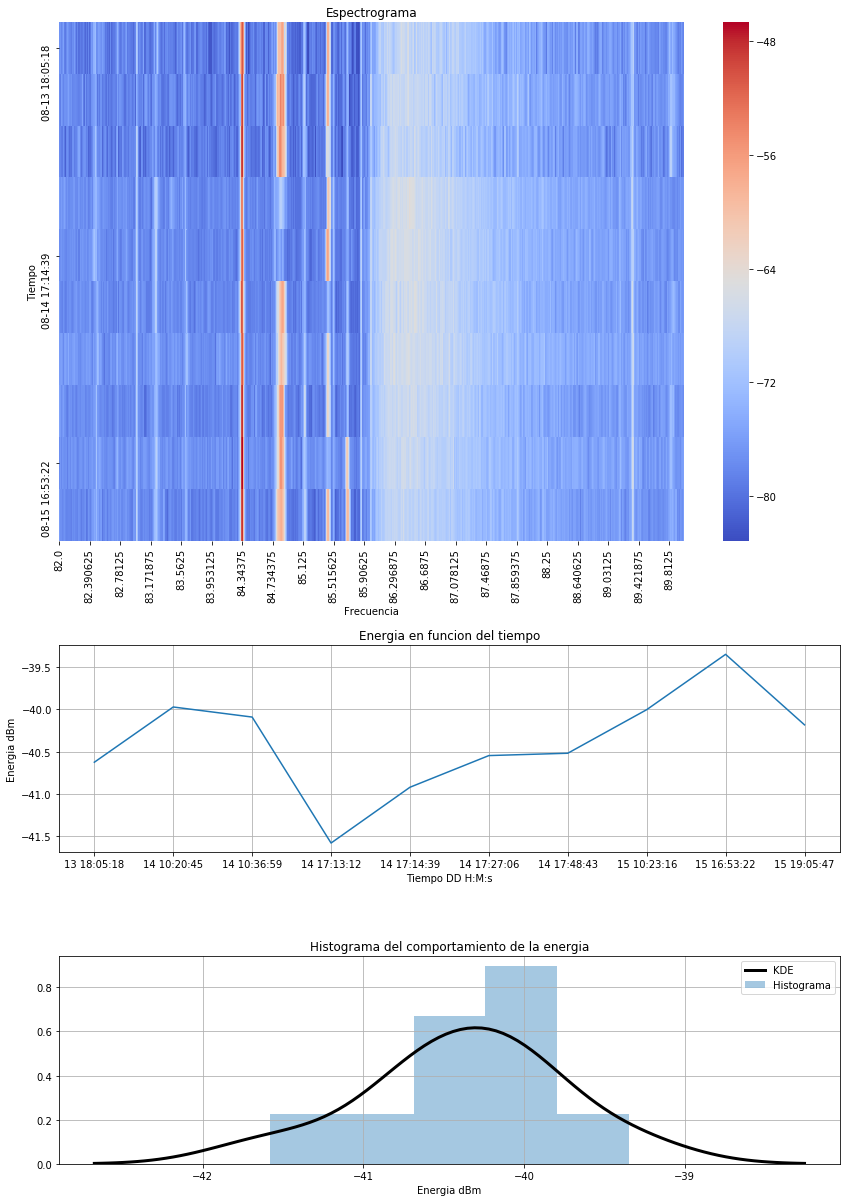

In [38]:
grid = plt.GridSpec(4, 1, wspace=0.4, hspace=0.5)
plt.figure(figsize=(14,21))
plt.subplot(grid[:2, 0])
sns.heatmap(df, yticklabels=4, xticklabels=50, cmap="coolwarm")
plt.title("Espectrograma")

plt.subplot(grid[2,0])
plt.plot(tiempo, 10*numpy.log10(char_ener))
plt.grid(True)
plt.xlabel("Tiempo DD H:M:s")
plt.ylabel("Energia dBm")
plt.title("Energia en funcion del tiempo")

plt.subplot(grid[3,0])
plt.title("Histograma del comportamiento de la energia")
sns.distplot(10*numpy.log10(char_ener), bins=5, kde_kws={"color": "k", "lw": 3, "label": "KDE"},
            hist_kws={"lw": 3, "label": "Histograma"})
plt.xlabel("Energia dBm")
plt.grid(True)

In [232]:
conn.close()

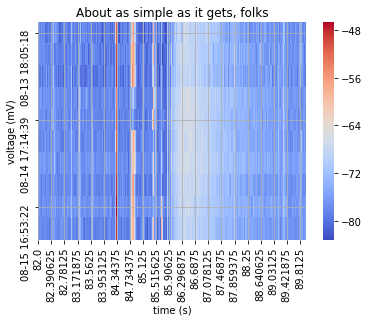

In [41]:
fig, ax = plt.subplots()
sns.heatmap(df, yticklabels=4, xticklabels=50, cmap="coolwarm", ax=ax)
ax.set(xlabel='time (s)', ylabel='voltage (mV)',
           title='About as simple as it gets, folks')
ax.grid()